# Two-step predict admissions using MSOA binned by IMD

Split the demographics data by IMD score to improve the correlation between the other variables.

Age proportions: proportion of patients in each age band.
Health proportions: proportion of patients with each of good, fair, and bad health.

There are two steps to predicting admission numbers in each IMD band:
+ Use the age-health fits to predict health proportions.
  + Each age band gives a separate set of health proportions from the age-health fits.
  + Combining the sets of health proportions with the known age proportions gives the health proportions across the whole MSOA.
+ Use the predicted health proportions with the health-admissions fits to predict admissions.

Both of these prediction steps use a linear regression.

## Code setup

In [1]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Patient demographics by MSOA:

In [2]:
path_to_msoa_stats = os.path.join('data', 'msoa_cleaned.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

In [3]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


Check sum of admissions for Welsh areas:

In [4]:
df_stats.filter(df_stats['country'] == 'W')['admissions'].sum()

0.0

Welsh data is always zero so remove it.

In [5]:
df_stats = df_stats.filter(df_stats['country'] != 'W')

Recalculate total numbers of patients:

In [6]:
df_stats = df_stats.with_columns((pl.col('good_health') + pl.col('fair health') + pl.col('bad health')).alias('total_health'))

In [7]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion,total_health
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64,i64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062,8524
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692,6634
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661,7100
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638,10127
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662,8526


Pick out column names for the health and age proportions:

In [8]:
health_numbers = ['good_health', 'fair health', 'bad health']
props_health = ['prop_good_health', 'prop_fair health', 'prop_bad health']
props_age = [
    'age_less65_proportion', 'age_65_proportion', 'age_70_proportion',
    'age_75_proportion', 'age_over80_proportion'
]

## Set up bins for IMD scores

Use quantiles so that each bin contains 10% of the MSOA (to match plot notebook).

The resulting dictionary has keys for which quantile it is and values for the left side (smaller, minimum value in bin) of the IMD bin.

In [9]:
dict_quantiles = {}

for q in np.arange(0.0, 1.01, 0.1):
    v = df_stats['IMD2019Score'].quantile(q)
    dict_quantiles[round(q, 1)] = round(v, 5)

In [10]:
dict_quantiles

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.3: 12.74375,
 0.4: 15.2564,
 0.5: 18.32929,
 0.6: 21.81475,
 0.7: 26.36117,
 0.8: 31.84075,
 0.9: 40.6996,
 1.0: 87.02675}

Pick out just the values for the left edges of the bins:

In [11]:
imd_bin_left_edges = {}
for k in list(dict_quantiles.keys())[:-1]:
    imd_bin_left_edges[k] = dict_quantiles[k]

In [12]:
imd_bin_left_edges

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.3: 12.74375,
 0.4: 15.2564,
 0.5: 18.32929,
 0.6: 21.81475,
 0.7: 26.36117,
 0.8: 31.84075,
 0.9: 40.6996}

Place MSOA into these bins:

In [13]:
# Make columns for the results with a placeholder value:
df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_min'))
df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_max'))

for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
    # Pick out the bin edges:
    q0 = dict_quantiles[quantile]
    q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
    # Find a mask for the demographic data that contains
    # only MSOA with IMD scores in this bin.
    mask = (df_stats['IMD2019Score'] >= q0) & (df_stats['IMD2019Score'] < q1)
    if q == len(dict_quantiles) - 2:
        # Also allow values at the right edge of the final bin.
        mask = mask | (df_stats['IMD2019Score'] == q1)

    # Update the bin min/max values for these rows:
    df_stats = df_stats.with_columns(
        pl.when((mask))
        .then(q0)         # replace with bin min
        .otherwise(pl.col('imd_bin_min'))  # otherwise keep the existing value
        .name.keep()
    )
    df_stats = df_stats.with_columns(
        pl.when((mask))
        .then(q1)         # replace with bin min
        .otherwise(pl.col('imd_bin_max'))  # otherwise keep the existing value
        .name.keep()
    )

Check that data was binned correctly:

In [14]:
df_stats[['IMD2019Score', 'imd_bin_min', 'imd_bin_max']]

IMD2019Score,imd_bin_min,imd_bin_max
f64,f64,f64
16.924833,15.2564,18.32929
6.4704,2.2122,7.708
13.7334,12.74375,15.2564
26.199857,21.81475,26.36117
11.7948,10.369,12.74375
…,…,…
3.25925,2.2122,7.708
7.29475,2.2122,7.708
12.117,10.369,12.74375


## Admissions from health: calculate line equations

Use the `scipy.optimize` function instead of the `statsmodels` because with `optimize` we can place bounds on the resulting coefficients. In this case we force all coefficients to be between 0 and 1 so that we can consider them as probabilities.

Calculate optimised coefficients for the following:

$$ a = c_g n_g + c_f n_f + c_b n_b$$

for admissions $a$, coefficients $c$, numbers of patients $n$, and health classifications of good $g$, fair $f$, and bad $b$.

Note that there is no constant in the equation. When the number of patients with good, fair and bad health is zero, the number of admissions is zero.

The following function multiplies the coefficients by the numbers of patients and sums the result:

In [15]:
def predict_admissions(x_lists, coeffs):
    """
    x_lists: np.array.
    coeffs: np.array.
    
    Have to have same number of coeffs as x_lists.
    """
    # Predicted admissions:
    yhat = (x_lists * coeffs.reshape(len(coeffs), 1)).sum(axis=0)
    return yhat

Goodness check option 1: This calculates the sum of the square of the differences between predicted and actual admission numbers:

In [16]:
def find_square_residuals(yhat, y):
    # Difference from actual:
    sqres = (yhat - y)**2.0
    # Sum of differences:
    sum_sqres = sqres.sum()
    return sum_sqres

Goodness check option 2: This calculates the mean absolute difference between the predicted and real admissions numbers:

In [17]:
def find_mean_abs_diff(yhat, y):
    # Difference from actual:
    absres = np.abs((yhat - y))
    # Mean of differences:
    mean_absres = absres.mean()
    return mean_absres

The following function combines the previous ones to do the main calculations we need:

In [18]:
def main_admissions(coeffs, args):
    x_lists = args[0]
    admissions = args[1]
    yhat = predict_admissions(x_lists, coeffs)
    # Use only one of the following options for checking the fit:
    sum_sqres = find_square_residuals(yhat, admissions)
    # sum_sqres = find_mean_abs_diff(yhat, admissions)
    return sum_sqres

To check accuracy, the following function calculates R-squared:

In [19]:
def calculate_rsquared(y, yhat):
    """This gives the same results as the sklearn built-in."""
    y_mean = y.mean()
    ss_res = ((yhat - y)**2.0).sum()
    ss_tot = ((y - y_mean)**2.0).sum()
    if ss_tot != 0.0:
        rsq = 1.0 - ss_res / ss_tot
    else:
        rsq = np.NaN
    return rsq

Predict the admissions numbers for all IMD bands:

In [20]:
# Store the results in this list:
list_dict_admissions_lines = []
        
for q, quantile_left in enumerate(list(imd_bin_left_edges.values())):
    mask = (df_stats['imd_bin_min'] == quantile_left)
    quantile_right = dict_quantiles[list(dict_quantiles.keys())[q + 1]]
    # Keep only those MSOA:
    df_stats_here = df_stats.filter(mask)

    # Set up data for the optimiser.
    # Initial guess for health coefficients:
    health_coeffs = [
        0.00005,  # P(stroke | good health)
        0.005,    # P(stroke | fair health)
        0.005     # P(stroke | bad health)
    ]
    # MSOA data in the same order as those coefficients:
    x_lists = [df_stats_here['good_health'], df_stats_here['fair health'], df_stats_here['bad health']]
    # Data for the optimiser function that should not be changed:
    args = [
        x_lists,
        df_stats_here['admissions']
    ]
    # Run the optimiser:
    opt_results = minimize(
        main_admissions,
        x0=health_coeffs,
        args=args,
        bounds=[(0.0, 1.0)] * len(health_coeffs),  # force results to lie between 0 and 1
        method='Nelder-Mead'
    )
    # Pick out the resulting health coefficients:
    coeffs = opt_results['x']
    # Use these coefficients to predict the admissions and so
    # calculate r-squared for accuracy of the fit.
    admissions_predicted = predict_admissions(x_lists, coeffs)
    r2 = calculate_rsquared(df_stats_here['admissions'], admissions_predicted)

    # Store the results in a dictionary:
    dict_admissions_lines = {}
    dict_admissions_lines['imd_bin_min'] = quantile_left
    dict_admissions_lines['imd_bin_max'] = quantile_right
    dict_admissions_lines['coeff_good_health'] = round(coeffs[0], 7)
    dict_admissions_lines['coeff_fair_health'] = round(coeffs[1], 7)
    dict_admissions_lines['coeff_bad_health'] = round(coeffs[2], 7)
    dict_admissions_lines['rsquared'] = round(r2, 7)
    # Store in big list of all results:
    list_dict_admissions_lines.append(dict_admissions_lines)

# Convert the list of dicts into a dataframe:
df_admissions_lines = pl.from_dicts(list_dict_admissions_lines)

Check the results:

In [21]:
df_admissions_lines

imd_bin_min,imd_bin_max,coeff_good_health,coeff_fair_health,coeff_bad_health,rsquared
f64,f64,f64,f64,f64,f64
2.2122,7.708,0.0,0.008549,0.017694,0.5722268
7.708,10.369,0.0,0.0101521,0.0091246,0.5156227
10.369,12.74375,0.0,0.0118571,0.0027425,0.5254204
12.74375,15.2564,0.0,0.0119053,0.0023227,0.565176
15.2564,18.32929,0.0,0.0121379,0.0,0.5270501
18.32929,21.81475,0.0,0.0116203,0.0000015,0.5140601
21.81475,26.36117,0.0,0.0110406,0.0006057,0.4988284
26.36117,31.84075,0.0,0.0093152,0.0031409,0.461555
31.84075,40.6996,0.0,0.0082107,0.0040624,0.4981876


Store a copy:

In [22]:
df_admissions_lines.write_csv(os.path.join('outputs', 'line_fits_health_to_admissions.csv'))

### Check accuracy

Predict admissions from real data to see how good these coefficients are.

In [23]:
def calculate_admissions_from_health(df_stats, df_admissions_lines, col_n_good, col_n_fair, col_n_bad):
    # Make a copy of the MSOA data:
    cols_to_keep = ['MSOA', 'IMD2019Score', 'admissions'] + props_health + [col_n_good, col_n_fair, col_n_bad]
    df_p_admissions = df_stats[cols_to_keep]
    # Make column for the results with a placeholder value:
    col_admissions_pred = 'admissions_predicted'
    df_p_admissions = df_p_admissions.with_columns(pl.lit(0).alias(col_admissions_pred))
    
    for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
        # Pick out the bin edges:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        # Find a mask for the demographic data that contains
        # only MSOA with IMD scores in this bin.
        mask = (df_p_admissions['IMD2019Score'] >= q0) & (df_p_admissions['IMD2019Score'] < q1)
        if q == len(dict_quantiles) - 2:
            # Also allow values at the right edge of the final bin.
            mask = mask | (df_p_admissions['IMD2019Score'] == q1)
    
        # Pick out the line parameters for this IMD:
        mask_coeffs = ((df_admissions_lines['imd_bin_min'] == q0))
        coeff_good = df_admissions_lines.filter(mask_coeffs)['coeff_good_health'].to_numpy()[0]
        coeff_fair = df_admissions_lines.filter(mask_coeffs)['coeff_fair_health'].to_numpy()[0]
        coeff_bad = df_admissions_lines.filter(mask_coeffs)['coeff_bad_health'].to_numpy()[0]

        # Calculate new props:
        df_p_admissions = df_p_admissions.with_columns(
            pl.when((mask))
            .then(
                sum([
                    coeff_good * df_p_admissions[col_n_good],
                    coeff_fair * df_p_admissions[col_n_fair],
                    coeff_bad * df_p_admissions[col_n_bad]
                ]))  # replace with calculated values
            .otherwise(pl.col(col_admissions_pred))  # otherwise keep the existing value
            .name.keep()
        )
    return df_p_admissions[['MSOA', 'admissions', col_admissions_pred]]

In [24]:
df_admissions_pred_from_real = calculate_admissions_from_health(df_stats, df_admissions_lines, 'good_health', 'fair health', 'bad health')

Check results:

In [25]:
df_admissions_pred_from_real.head()

MSOA,admissions,admissions_predicted
str,f64,f64
"""Adur 001""",14.333333,15.184513
"""Adur 002""",7.333333,11.746808
"""Adur 003""",9.333333,12.258595
"""Adur 004""",21.0,17.498209
"""Adur 005""",13.666667,13.747233


Calculate r-squared of this fit:

In [26]:
rsq = calculate_rsquared(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_predicted']
)

rsq

0.5135151159801523

Plot predicted vs real admission numbers:

40.333333332


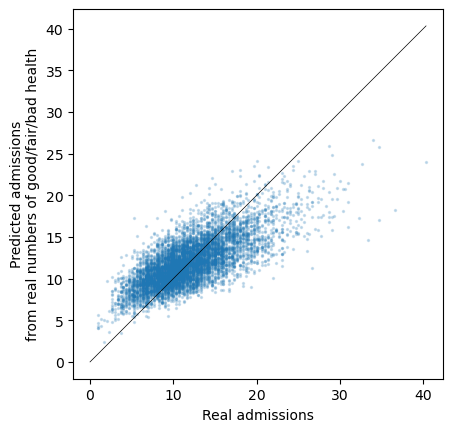

In [27]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions', 'admissions_predicted']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_predicted'],
    s=2, alpha=0.2
)

ax.set_xlabel('Real admissions')
ax.set_ylabel('Predicted admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

40.333333332


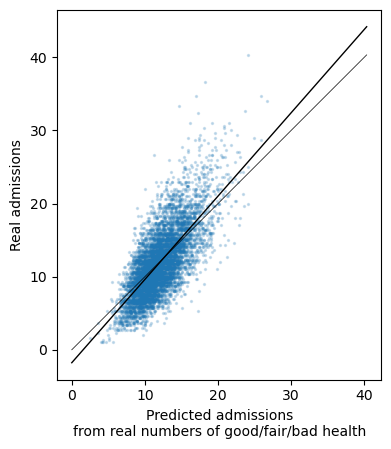

In [47]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions_predicted', 'admissions']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Fit line:
ax.plot([0, ad_max], [c, ad_max*m + c], color='k', linewidth=1)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions_predicted'],
    df_admissions_pred_from_real['admissions'],
    s=2, alpha=0.2
)

ax.set_ylabel('Real admissions')
ax.set_xlabel('Predicted admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

### Fudge factor

Fit a straight line for real admissions from predicted:

In [31]:
# Fit a line to this selection:
y = (df_admissions_pred_from_real['admissions']).to_numpy()
X = df_admissions_pred_from_real['admissions_predicted'].to_numpy()
# Add the constant:
X = sm.add_constant(X)
# Fit line:
model = sm.OLS(y, X)
results = model.fit()
# Pick out coeffs, R^2:
coeffs = results.params
r2 = results.rsquared

In [32]:
m = coeffs[1]
c = coeffs[0]

coeffs

array([-1.77072816,  1.13939575])

In [33]:
r2

0.5217702362761149

In [49]:
# Lines y=x and y=mx+c intersect at this x:
xp = c / (1 - m)
# And this y:
yp = m*xp + c

In [60]:
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns(((pl.col('admissions_predicted') - yp)*m + yp).alias('admissions_fudged'))

In [61]:
df_admissions_pred_from_real.head()

MSOA,admissions,admissions_predicted,admissions_fudged
str,f64,f64,f64
"""Adur 001""",14.333333,15.184513,15.530441
"""Adur 002""",7.333333,11.746808,11.613535
"""Adur 003""",9.333333,12.258595,12.196663
"""Adur 004""",21.0,17.498209,18.166657
"""Adur 005""",13.666667,13.747233,13.89281


In [62]:
rsq = calculate_rsquared(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_fudged']
)

rsq

0.521770236276115

40.333333332


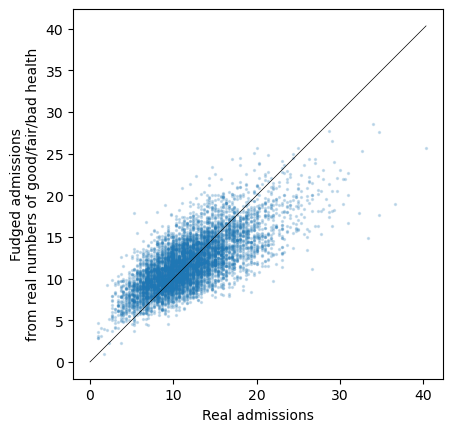

In [63]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions', 'admissions_fudged']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_fudged'],
    s=2, alpha=0.2
)

ax.set_xlabel('Real admissions')
ax.set_ylabel('Fudged admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

40.333333332


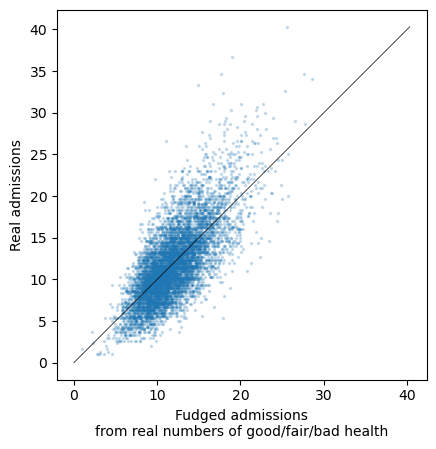

In [64]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions_fudged', 'admissions']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions_fudged'],
    df_admissions_pred_from_real['admissions'],
    s=2, alpha=0.2
)

ax.set_ylabel('Real admissions')
ax.set_xlabel('Fudged admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

## Health from age: calculate line equations

This function uses `statsmodels` to find a linear regression fit between age and health data.

In [28]:
def make_dict_age_health_predictions(df_stats_here, y_col, age_col):
    # Fit a line to this selection:
    y = (df_stats_here[y_col]).to_numpy()
    X = df_stats_here[age_col].to_numpy()
    # Add the constant:
    X = sm.add_constant(X)
    # Fit line:
    model = sm.OLS(y, X)
    results = model.fit()
    # Pick out coeffs, R^2:
    coeffs = results.params
    r2 = results.rsquared
    return coeffs, r2

Calculate and store all line equations found using that function:

In [29]:
list_dict_health_lines = []

for q, quantile_left in enumerate(imd_bin_left_edges.values()):
    mask = (df_stats['imd_bin_min'] == quantile_left)
    quantile_right = dict_quantiles[list(dict_quantiles.keys())[q+1]]    

    # Only keep data for MSOAs with IMD scores in this range:
    df_stats_here = df_stats.filter(mask)
    
    for ix, age_col in enumerate(props_age):
        for iy, health_col in enumerate(props_health):
            # Calculate results:
            coeffs, r2 = make_dict_age_health_predictions(df_stats_here, health_col, age_col)
            # Make a dictionary of the results:
            dict_health_lines = {}
            dict_health_lines['imd_bin_min'] = quantile_left
            dict_health_lines['imd_bin_max'] = quantile_right
            dict_health_lines['col_age'] = age_col
            dict_health_lines['col_health'] = health_col
            dict_health_lines['m'] = round(coeffs[1], 7)
            dict_health_lines['c'] = round(coeffs[0], 7)
            dict_health_lines['rsquared'] = round(r2, 7)

            list_dict_health_lines.append(dict_health_lines)

# Gather list of dicts into a dataframe:
df_health_lines = pl.from_dicts(list_dict_health_lines)

View results:

In [30]:
df_health_lines

imd_bin_min,imd_bin_max,col_age,col_health,m,c,rsquared
f64,f64,str,str,f64,f64,f64
2.2122,7.708,"""age_less65_proportion""","""prop_good_health""",0.3543778,0.5874175,0.6364851
2.2122,7.708,"""age_less65_proportion""","""prop_fair health""",-0.264882,0.3105843,0.6541842
2.2122,7.708,"""age_less65_proportion""","""prop_bad health""",-0.089496,0.1019982,0.4586286
2.2122,7.708,"""age_65_proportion""","""prop_good_health""",-1.484968,0.9440812,0.4800753
2.2122,7.708,"""age_65_proportion""","""prop_fair health""",1.1150576,0.0437121,0.497979
…,…,…,…,…,…,…
40.6996,87.02675,"""age_75_proportion""","""prop_fair health""",1.4784728,0.122669,0.5286341
40.6996,87.02675,"""age_75_proportion""","""prop_bad health""",0.9697874,0.0655171,0.2502796
40.6996,87.02675,"""age_over80_proportion""","""prop_good_health""",-1.675397,0.8101677,0.3973811


Store a copy:

In [31]:
df_health_lines.write_csv(os.path.join('outputs', 'line_fits_age_to_health.csv'))

### Check accuracy

Use the real age proportions to calculate new health proportions.

In [32]:
# Make a copy of the MSOA data:
cols_to_keep = ['MSOA', 'total_health', 'admissions', 'IMD2019Score'] + props_age + props_health
df_p_health_props = df_stats[cols_to_keep]#.clone()
# Make columns for the results with a placeholder value:
for p in props_health:
    new_col = f'{p}_pred'
    df_p_health_props = df_p_health_props.with_columns(pl.lit(0).alias(new_col))

for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
    # Pick out the bin edges:
    q0 = dict_quantiles[quantile]
    q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
    # Find a mask for the demographic data that contains
    # only MSOA with IMD scores in this bin.
    mask = (df_p_health_props['IMD2019Score'] >= q0) & (df_p_health_props['IMD2019Score'] < q1)
    if q == len(dict_quantiles) - 2:
        # Also allow values at the right edge of the final bin.
        mask = mask | (df_p_health_props['IMD2019Score'] == q1)

    # Pick out the line parameters for this IMD / age combo:
    for health_col in props_health:
        for age_band in props_age:
            # Pick out line params:
            mask_line = (
                (df_health_lines['imd_bin_min'] == q0) &
                (df_health_lines['col_age'] == age_band) &
                (df_health_lines['col_health'] == health_col)
            )
            m = df_health_lines.filter(mask_line)['m'].to_numpy()[0]
            c = df_health_lines.filter(mask_line)['c'].to_numpy()[0]

            # mask_here = mask & ()
            # Calculate new props:
            df_p_health_props = df_p_health_props.with_columns(
                pl.when((mask))
                .then(m * df_p_health_props[age_band] + c)  # replace with calculated values
                .otherwise(pl.col(f'{health_col}_pred'))  # otherwise keep the existing value
                .name.keep()
            )

View the results:

In [33]:
df_p_health_props

MSOA,total_health,admissions,IMD2019Score,age_less65_proportion,age_65_proportion,age_70_proportion,age_75_proportion,age_over80_proportion,prop_good_health,prop_fair health,prop_bad health,prop_good_health_pred,prop_fair health_pred,prop_bad health_pred
str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Adur 001""",8524,14.333333,16.924833,0.7872,0.0559,0.0528,0.0422,0.062,0.79763,0.146762,0.055608,0.813224,0.13524,0.051536
"""Adur 002""",6634,7.333333,6.4704,0.7467,0.0578,0.0774,0.0492,0.0692,0.83464,0.126319,0.039041,0.858487,0.10795,0.033564
"""Adur 003""",7100,9.333333,13.7334,0.7729,0.0609,0.0582,0.0421,0.0661,0.819718,0.136479,0.043803,0.821459,0.131242,0.047299
"""Adur 004""",10127,21.0,26.199857,0.8091,0.0465,0.0438,0.0367,0.0638,0.777328,0.152661,0.070011,0.781694,0.153039,0.065267
"""Adur 005""",8526,13.666667,11.7948,0.7643,0.0597,0.067,0.0425,0.0662,0.833451,0.126789,0.039761,0.830716,0.125518,0.043766
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""York 020""",6540,14.333333,3.25925,0.7301,0.0595,0.0743,0.0555,0.0806,0.831957,0.128135,0.039908,0.848442,0.115395,0.036163
"""York 021""",7039,12.666667,7.29475,0.8052,0.0509,0.0456,0.0377,0.0606,0.870152,0.099446,0.030402,0.866064,0.102333,0.031603
"""York 022""",9165,16.333333,12.117,0.7629,0.0594,0.0675,0.046,0.0641,0.818658,0.136498,0.044845,0.832885,0.123909,0.043206


Plot the match between the real health proportions and the predicted values:

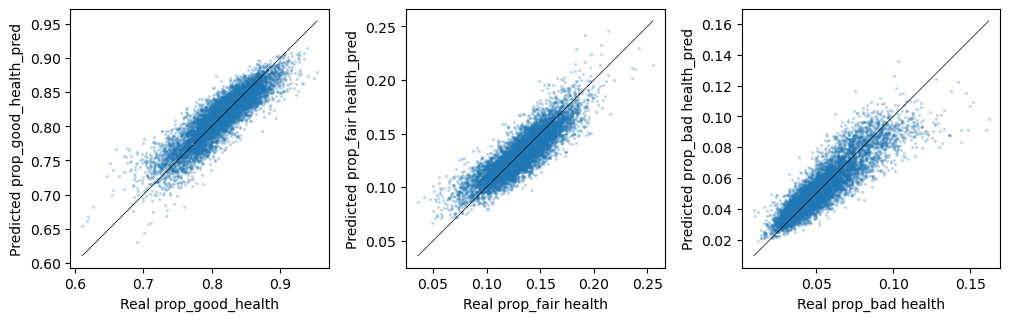

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

for i, health_name in enumerate(['good_health', 'fair health', 'bad health']):
    real_col = f'prop_{health_name}'
    pred_col = f'prop_{health_name}_pred'
    ax = axs[i]
    ax.scatter(df_p_health_props[real_col], df_p_health_props[pred_col], s=2, alpha=0.2)
    # Draw equal line:
    vmin = df_p_health_props[[real_col, pred_col]].min().min_horizontal()
    vmax = df_p_health_props[[real_col, pred_col]].max().max_horizontal()
    ax.plot([vmin, vmax], [vmin, vmax], color='k', linewidth=0.5)
    ax.set_xlabel('Real ' + real_col)
    ax.set_ylabel('Predicted ' + pred_col)
    ax.set_aspect('equal')
plt.show()

## Predict admissions from age proportions

Bring the two models together.

Use the health proportions that have just been calculated and use the admissions prediction function from before.

First convert proportions of each health type into numbers with each health type:

In [35]:
df_p_health_props = df_p_health_props.with_columns((pl.col('prop_good_health_pred') * pl.col('total_health')).alias('n_good_health_pred'))
df_p_health_props = df_p_health_props.with_columns((pl.col('prop_fair health_pred') * pl.col('total_health')).alias('n_fair health_pred'))
df_p_health_props = df_p_health_props.with_columns((pl.col('prop_bad health_pred') * pl.col('total_health')).alias('n_bad health_pred'))

In [36]:
df_admissions_pred_from_pred = calculate_admissions_from_health(df_p_health_props, df_admissions_lines, 'n_good_health_pred', 'n_fair health_pred', 'n_bad health_pred')

Check results:

In [37]:
df_admissions_pred_from_pred.head()

MSOA,admissions,admissions_predicted
str,f64,f64
"""Adur 001""",14.333333,13.992369
"""Adur 002""",7.333333,10.062044
"""Adur 003""",9.333333,11.873597
"""Adur 004""",21.0,17.51136
"""Adur 005""",13.666667,13.712387


Save a copy:

In [38]:
df_admissions_pred_from_pred.write_csv(os.path.join('outputs', 'admissions_from_twostep.csv'))

Check accuracy by calculating R-squared:

In [39]:
rsq = calculate_rsquared(
    df_admissions_pred_from_pred['admissions'],
    df_admissions_pred_from_pred['admissions_predicted']
)

rsq

0.47902976537608155

Plot predicted vs real admissions:

40.333333332


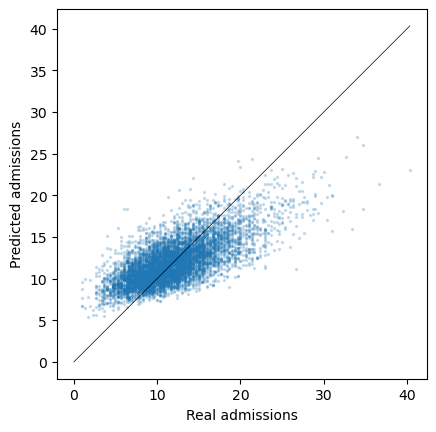

In [40]:
fig, ax = plt.subplots()

ad_max = df_admissions_pred_from_pred[['admissions', 'admissions_predicted']].max().max_horizontal().to_numpy()[0]
print(ad_max)
# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_pred['admissions'],
    df_admissions_pred_from_pred['admissions_predicted'],
    s=2, alpha=0.2
)

ax.set_xlabel('Real admissions')
ax.set_ylabel('Predicted admissions')

ax.set_aspect('equal')
plt.show()